# Download the data from Kaggle and extract the files.

In [2]:
import os
os.environ["PATH"] += os.pathsep + os.path.expanduser("~/.local/bin")
os.environ["PYTHONPATH"] += os.pathsep + os.path.expanduser("~/.local/lib/python3.11/site-packages")

In [23]:
!kaggle datasets download -d jeffsinsel/nyc-fhvhv-data --path ~/kaggle_test/

Dataset URL: https://www.kaggle.com/datasets/jeffsinsel/nyc-fhvhv-data
License(s): CC0-1.0
100%|█████████████████████████████████████▉| 17.8G/17.8G [09:36<00:00, 40.8MB/s]
100%|██████████████████████████████████████| 17.8G/17.8G [09:36<00:00, 33.3MB/s]


In [4]:
!kaggle datasets download -d salikhussaini49/nyc-tlc-trip-record-data-repository --path ~/kaggle_test/

... resuming from 18447597568 bytes (39723556602 bytes left) ...
100%|█████████████████████████████████████▉| 54.2G/54.2G [30:06<00:00, 29.3MB/s]
100%|██████████████████████████████████████| 54.2G/54.2G [30:06<00:00, 22.0MB/s]


In [1]:
!kaggle datasets download -d salikhussaini49/nyc-tlc-trip-record-data-repository --path ~/kaggle_test/ --force


/bin/bash: line 1: kaggle: command not found


In [ ]:
!unzip ~/kaggle_test/nyc-tlc-trip-record-data-repository.zip -d ~/kaggle_test/data2


Archive:  /home/sseo/kaggle_test/nyc-tlc-trip-record-data-repository.zip
  inflating: /home/sseo/kaggle_test/data2/data_shape_2.csv  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-01.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-02.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-03.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-04.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-05.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-06.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-07.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-08.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-09.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-10.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-11.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-12.

# Goal Of this Part: 
During this project, I aim to examine how pricing policies differ across taxi companies.

As a simple approach, I plan to analyze how fares are determined based on trip distance for each company (excluding tips). The slope of the line between distance and fare will serve as an indicator: the steeper the slope, the more expensive the company's pricing policy can be considered.

## 1. Library Loading

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import min, max, col, when
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

## 2. Data Loading
(Beacuse of limitation of the Capacity of the memory, I just used only 3 parquets for this project)

In [16]:
spark = SparkSession.builder \
    .appName("FHVHV Trip Data Analysis") \
    .getOrCreate()

file_list = sorted(glob.glob("./data1/fhvhv_tripdata_*.parquet"))[:3]
df = spark.read.parquet(*file_list)

print("total row:", df.count())

total row: 65758522


## 3. Data Preprocessing
1) Mapping taxi company codes to their names:
"HV0002": "Juno",
"HV0003": "Uber",
"HV0004": "Via",
"HV0005": "Ly
   

In [17]:
df = df.withColumn(
    "company",
    when(df["hvfhs_license_num"] == "HV0002", "Juno")
    .when(df["hvfhs_license_num"] == "HV0003", "Uber")
    .when(df["hvfhs_license_num"] == "HV0004", "Via")
    .when(df["hvfhs_license_num"] == "HV0005", "Lyft")
    .otherwise("Other")  
)

2. Perform numeric preprocessing to calculate the total amount.

In [18]:
df = df.fillna({
    "base_passenger_fare": 0,
    "tolls": 0,
    "bcf": 0,
    "sales_tax": 0,
    "congestion_surcharge": 0,
    "airport_fee": 0,
    "tips": 0
})

3. Define the maximum values for distance and fare in order to calculate total_amount and compare the data.
- max distance : 10 miles

In [19]:
df = df.withColumn("total_amount",
    col("base_passenger_fare") +
    col("tolls") +
    col("bcf") +
    col("sales_tax") +
    col("congestion_surcharge") +
    col("airport_fee"))

#Sample the data to improve visualization performance.
df_sample = df.select("company", "trip_miles", "total_amount")

df_pd = df_sample.sample(fraction=0.05).toPandas()
df_pd= df_pd[df_pd['trip_miles']<=10]
df_pd= df_pd[df_pd['total_amount']<=50]

# 4. Data visualization
1. Looking at the boxplot, Via appears to have the lowest median fare, suggesting it is relatively inexpensive. The fare range also seems more limited compared to others, although it shows large outliers.
2. 

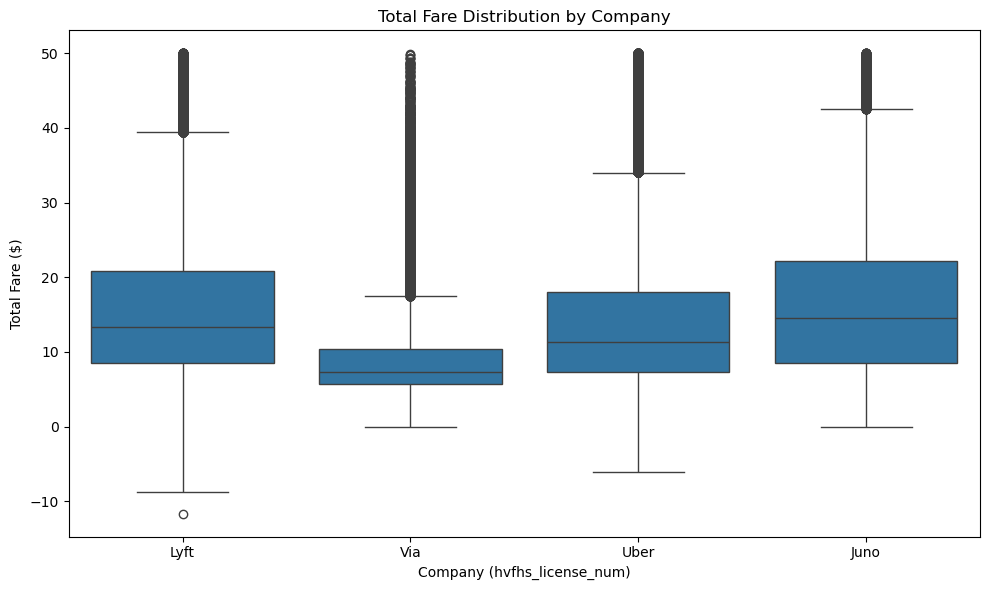

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_pd,
    x="company",   
    y="total_amount"  
)
plt.title("Total Fare Distribution by Company")
plt.xlabel("Company (hvfhs_license_num)")
plt.ylabel("Total Fare ($)")
plt.tight_layout()
plt.show()

# Result 
Based on the results, the lowest cost per mile was observed in the order of
Via > Uber > Lyft > Juno.
(However, in the case of Via, most of the data is concentrated around shorter trip distances, so this should be taken into account when comparing prices.)
The relatively low R² scores for Via and Uber suggest that although their fares are lower, the fare variability is higher.

In [31]:
summary = []

for company in df_pd['company'].unique():
    df_c = df_pd[df_pd['company'] == company]

    X = df_c[['trip_miles']]
    y = df_c['total_amount']

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)

    summary.append({
        'Company': company,
        'R²': round(r2, 4),
        'RMSE': round(rmse, 2)
    })

    print(f"\n[{company}]  R² = {r2:.4f}  |  RMSE = ${rmse:.2f}")
    print("Sample predictions:")
    sample = df_c[['trip_miles', 'total_amount']].copy()
    sample['predicted'] = y_pred
    print(sample.head(5).round(2).to_string(index=False))

print("\n" + "=" * 60)
print("Summary by Company")
print(pd.DataFrame(summary).to_string(index=False))


[Lyft]  R² = 0.6096  |  RMSE = $5.80
Sample predictions:
 trip_miles  total_amount  predicted
       1.15          5.48       8.81
       6.38         21.05      26.99
       5.28         22.74      23.52
       1.82         25.56      11.37
       2.42         10.95      13.34

[Via]  R² = 0.4924  |  RMSE = $3.62
Sample predictions:
 trip_miles  total_amount  predicted
       4.63          7.89      10.47
       1.59          8.71       6.45
       5.09          9.74      13.17
       7.75         16.88      17.57
       6.04          8.66      14.15

[Uber]  R² = 0.3910  |  RMSE = $7.06
Sample predictions:
 trip_miles  total_amount  predicted
       6.59          7.13      21.89
       2.20          6.24      11.32
       1.37          4.54       8.85
       2.67         12.32      12.75
       3.98         21.39      15.95

[Juno]  R² = 0.6353  |  RMSE = $5.81
Sample predictions:
 trip_miles  total_amount  predicted
       6.90         19.09      29.21
       0.86          4.29    

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

results = []

for name in df_pd['company'].unique():
    subset = df_pd[df_pd['company'] == name]

    X = subset[['trip_miles']]
    y = subset['total_amount']

    model = LinearRegression()
    model.fit(X, y)

    pred = model.predict(X)
    rmse = mean_squared_error(y, pred, squared=False)

    results.append({
        'Company': name,
        'Cost per mile': model.coef_[0],
        'Base fare': model.intercept_,
        'R²': model.score(X, y),
        'RMSE': rmse
    })

summary_df = pd.DataFrame(results)
summary_df = summary_df.round({'Cost per mile': 2, 'Base fare': 2, 'R²': 4, 'RMSE': 2})
print(summary_df)

  Company  Cost per mile  Base fare      R²  RMSE
0    Lyft           3.18       5.70  0.6047  5.84
1     Via           1.73       3.62  0.4728  3.69
2    Uber           2.49       5.81  0.3887  7.08
3    Juno           3.32       6.45  0.6174  5.95


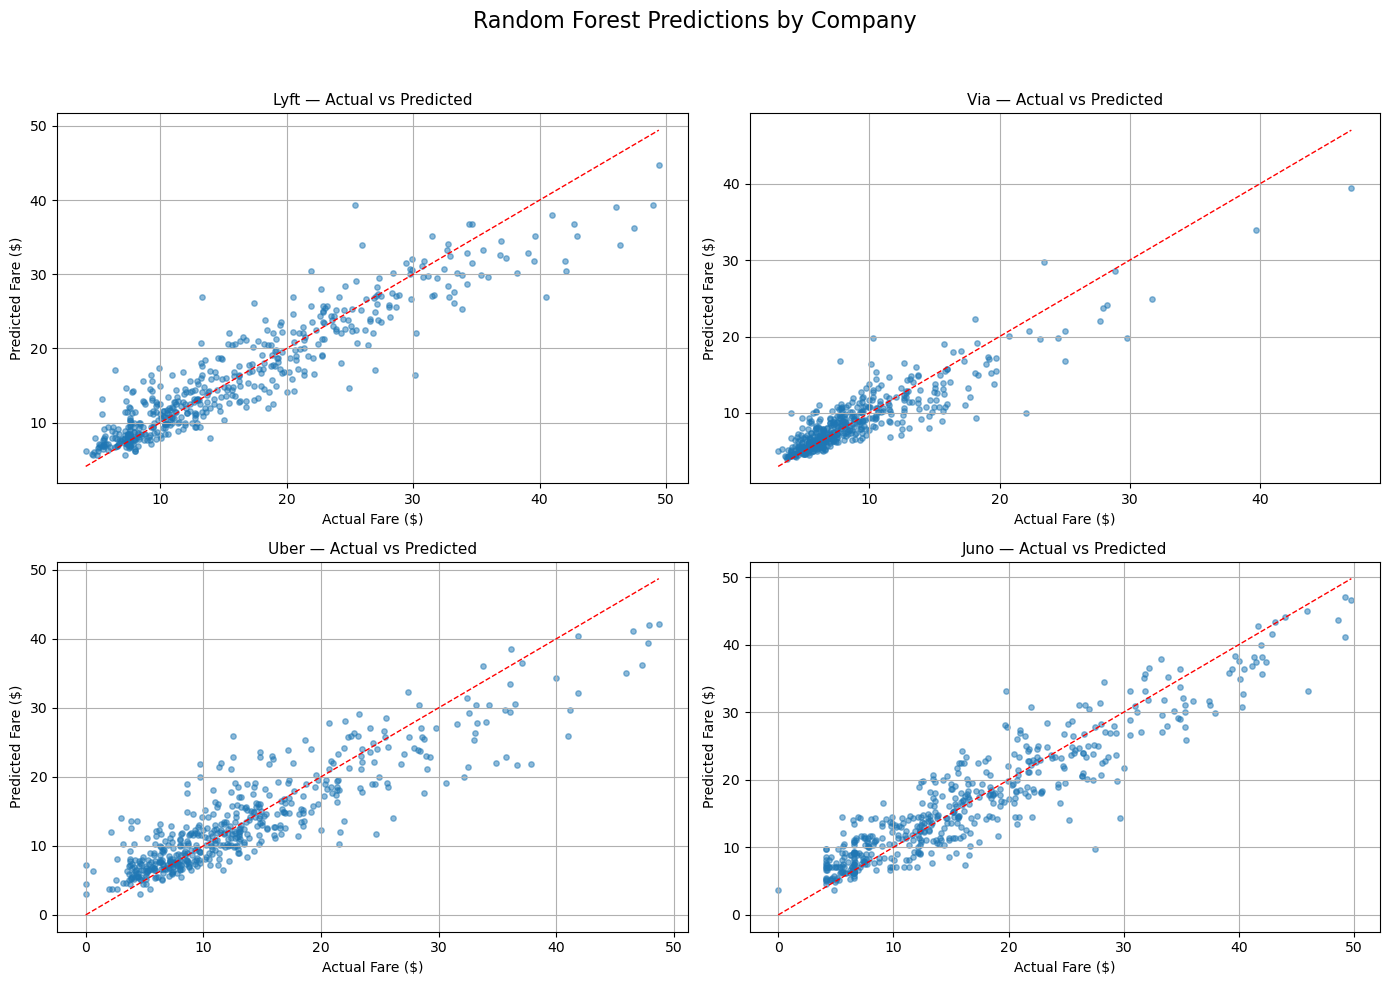

In [33]:
companies = df_pd['company'].unique()
n_companies = len(companies)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, company in enumerate(companies):
    df_c = df_pd[df_pd['company'] == company].sample(n=500, random_state=42)

    X = df_c[['trip_miles']]
    y = df_c['total_amount']

    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X, y)
    y_pred = model.predict(X)

    ax = axs[i]
    ax.scatter(y, y_pred, alpha=0.5, s=15)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=1)
    ax.set_title(f"{company} — Actual vs Predicted", fontsize=11)
    ax.set_xlabel("Actual Fare ($)")
    ax.set_ylabel("Predicted Fare ($)")
    ax.grid(True)

fig.suptitle("Random Forest Predictions by Company", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Conclusion :
In this model, the analysis focused solely on the relationship between distance and fare across the four taxi companies. However, in the future, I believe a more complex and multidimensional analysis can be conducted by leveraging additional features available in the dataset.

Possible improvements:
- Increase the volume of data used,
- Analyze the data across different time periods,
- Conduct statistical comparisons between companies.